# Question 1

In [1]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
from math import isnan

In [2]:
##Below code was taken from our lab

In [3]:
# undirected graph degree correlation
def deg_corr(G):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree())])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree()
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        # w = [deg[i] for i in list(set(G.neighbors(v)))] 
        w = [deg[i] for i in G.neighbors(v)] 
        L[idx[v.degree()]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L))}

# degree correlation for neutral graphs: <k^2>/<k>
# to find uncorrelated knn
def deg_corr_neutral(G, mode='all'):
    x = G.degree(mode=mode)
    return np.mean([i**2 for i in x])/np.mean(x)   

# for a fixed l 
def richClub(g, l=1):
    g.vs()['degree'] = g.degree()
    l_max = np.max(g.degree())
    c = Counter(g.degree())
    n = g.vcount()
    moment = np.sum([k*c[k]/n for k in c])**2
    S = [k*c[k]/n for k in c if k>=l]
    phi_hat = np.sum([x*y for x in S for y in S])*g.ecount()/moment
    G = g.subgraph([v for v in g.vs() if v['degree']>=l])
    phi = G.ecount()
    return phi/phi_hat 


## Correlation exponent via linear regression (taking logs)
def corr_exp(G):
    ## compute knn's
    knn = deg_corr(G)
    
    try:
        # Fit the regression
        regressor = LinearRegression()  
        x = [np.log(i) for i in knn.keys()]
        y = [np.log(i) for i in knn.values()]
        regressor.fit(np.array(x).reshape(-1,1), y)
        return regressor.coef_[0]

    except:
        #removes NAN values
        knn = {key: knn[key] for key in knn if not isnan(knn[key])}
        
        # Fit the regression
        regressor = LinearRegression()  
        x = [np.log(i) for i in knn.keys()]
        y = [np.log(i) for i in knn.values()]
        regressor.fit(np.array(x).reshape(-1,1), y)
        return regressor.coef_[0]

In [4]:
## GitHub Developers (undirected)
D = pd.read_csv('musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
github_graph = ig.Graph.TupleList(tuples, directed = False)

## read node features
X = pd.read_csv('musae_git_target.csv')

## map node names in edgelist to indices in the graph
idx = [int(i) for i in github_graph.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex) 
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)

cls = ['grey','black'] ## node colors
lbl = ['web','ml']     ## node labels
github_graph.es['color'] = 'grey' ## edge color

## there are 2 node types: ml or web
github_graph.vs['color'] = [cls[i] for i in list(X['ml_target'])]
github_graph.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]


# building the subgraphs
github_graph_ml = github_graph.subgraph([v for v in github_graph.vs() if v['lbl']=='ml'])
github_graph_web = github_graph.subgraph([v for v in github_graph.vs() if v['lbl']=='web'])

# Number of nodes
print('GitHub nodes:',github_graph.vcount(),'; ml developers:',github_graph_ml.vcount(),'; web developers:',github_graph_web.vcount())


GitHub nodes: 37700 ; ml developers: 9739 ; web developers: 27961


In [5]:
# removing loops

github_graph = github_graph.simplify(multiple=False)
github_graph_ml = github_graph_ml.simplify(multiple=False)
github_graph_web = github_graph_web.simplify(multiple=False)

# Original Graph

dotted horizontal line shows uncorrelated knn, which is  441.020594941921


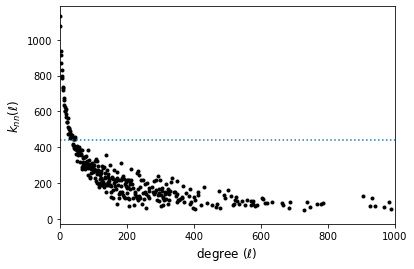

In [6]:
LIM = 1000 #degree limit for a clearer graph

knn = deg_corr(github_graph)

x = list(knn.keys())
y = list(knn.values())

knn2 = deg_corr_neutral(github_graph) #gives us uncorrelated knn

plt.xlim((0,LIM))
plt.scatter(x,y,marker='.',c='black')

plt.hlines(y=knn2,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
print("dotted horizontal line shows uncorrelated knn, which is ", knn2)

In [7]:
#degree correlation coefficient r (often referred to as assortativity)
#correlation exponent (mu) via regression

print("degree correlation coefficient r: ", github_graph.assortativity_degree())
print("correlation exponent (mu) ", corr_exp(github_graph))

degree correlation coefficient r:  -0.07521713413904482
correlation exponent (mu)  -0.5076879013701247


given p(l) < 1, there is evidence for anti-rich club


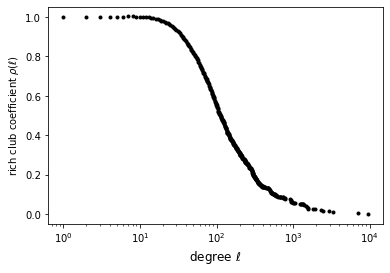

In [8]:
## Rich club 
d = list(set(github_graph.degree()))
rc = []
for i in d:
    rc.append(richClub(github_graph, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
print("given p(l) < 1, there is evidence for anti-rich club")

# ML Developers

dotted horizontal line shows uncorrelated knn, which is  36.43680146311726


C:\Users\G\anaconda3\envs\tensorflow_sessions\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\G\anaconda3\envs\tensorflow_sessions\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


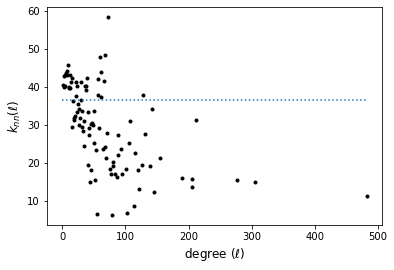

In [9]:
knn = deg_corr(github_graph_ml)

x = list(knn.keys())
y = list(knn.values())

knn2 = deg_corr_neutral(github_graph_ml) #gives us uncorrelated knn


plt.scatter(x,y,marker='.',c='black')

plt.hlines(y=knn2,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12)
print("dotted horizontal line shows uncorrelated knn, which is ", knn2)

In [10]:
#degree correlation coefficient r (often referred to as assortativity)
#correlation exponent (mu) via regression

print("degree correlation coefficient r: ", github_graph_ml.assortativity_degree())
print("correlation exponent (mu) ", corr_exp(github_graph_ml))

degree correlation coefficient r:  -0.09098692775064464
correlation exponent (mu)  -0.25142348768180356


<ipython-input-3-fb3b56470193>:41: RuntimeWarning: divide by zero encountered in log
  x = [np.log(i) for i in knn.keys()]


given p(l) < 1, there is evidence for anti-rich club


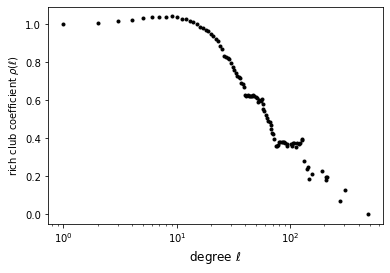

In [11]:
## Rich club 
d = list(set(github_graph_ml.degree()))
rc = []
for i in d:
    rc.append(richClub(github_graph_ml, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$')
print("given p(l) < 1, there is evidence for anti-rich club")

# Web Developers

dotted horizontal line shows uncorrelated knn, which is  420.39156275181074


C:\Users\G\anaconda3\envs\tensorflow_sessions\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\G\anaconda3\envs\tensorflow_sessions\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


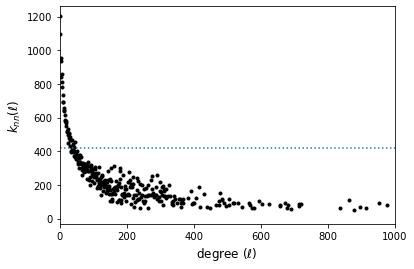

In [12]:
knn = deg_corr(github_graph_web)

LIM = 1000 #degree limit for a clearer graph

x = list(knn.keys())
y = list(knn.values())

knn2 = deg_corr_neutral(github_graph_web) #gives us uncorrelated knn

plt.xlim((0,LIM))
plt.scatter(x,y,marker='.',c='black')

plt.hlines(y=knn2,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12)
print("dotted horizontal line shows uncorrelated knn, which is ", knn2)

In [13]:
#degree correlation coefficient r (often referred to as assortativity)
#correlation exponent (mu) via regression

print("degree correlation coefficient r: ", github_graph_web.assortativity_degree())
print("correlation exponent (mu) ", corr_exp(github_graph_web))

degree correlation coefficient r:  -0.08714757315866846
correlation exponent (mu)  -0.5151040696086917


<ipython-input-3-fb3b56470193>:41: RuntimeWarning: divide by zero encountered in log
  x = [np.log(i) for i in knn.keys()]


given p(l) < 1, there is evidence for anti-rich club


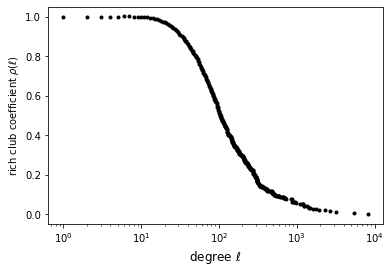

In [14]:
## Rich club 
d = list(set(github_graph_web.degree()))
rc = []
for i in d:
    rc.append(richClub(github_graph_web, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$')
print("given p(l) < 1, there is evidence for anti-rich club")